Chaine de prétraitement des données

# Librairies

In [58]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
from pathlib import Path
import random
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT

# 1. Création du folder Test1

On va sélectionner pour chaque catégorie d'image 3 images aléatoires et créer une arborescence.

Le dossier d'images utilisé pour créer Test1 sont celles de ce dossier : fruits-360_dataset\fruits-360\Test

## 1.1. Paths

In [2]:
random.seed(42)

In [3]:
images_folder_filepath = "/home/maxime/projects/P9/data/Images/Test"
main_folder = Path(images_folder_filepath)

test1_folder_filepath = "/home/maxime/projects/P9/data/Images/Test1"
output_folder = Path(test1_folder_filepath)

IMAGE_EXTENSIONS = {".jpg"} # Définition des extensions d'images valides
NUM_IMAGES_TO_SELECT = 3
selected_image_paths = [] # La liste qui contiendra tous les chemins des images sélectionnées

## 1.2. Sélection des images et de leurs classes

In [4]:
if output_folder.is_dir():
    print(f"Le dossier d'images Test1 existe déja")
else:
    print(f"Sélection des images à mettre dans le dossier d'images Test1")

    # On parcourt chaque élément (fichier ou dossier) dans le dossier principal
    for subfolder in main_folder.iterdir():
        
        # Vérifiez que l'élément est bien un dossier
        if subfolder.is_dir():
            print(f"--- Traitement du sous-dossier : {subfolder.name} ---")
            
            # Listez toutes les images valides dans ce sous-dossier
            images_in_subfolder = [
                item for item in subfolder.iterdir() 
                if item.is_file() and item.suffix.lower() in IMAGE_EXTENSIONS
            ]
            
            num_found = len(images_in_subfolder) #Permet de d'assurer qu'on a au moins 3 images à sélectionner dedans

            # S'il y a assez d'images, on en sélectionne 3 au hasard
            if num_found >= NUM_IMAGES_TO_SELECT:
                print(f"Trouvé {num_found} images. Sélection de {NUM_IMAGES_TO_SELECT} au hasard.")
                selected_samples = random.sample(images_in_subfolder, NUM_IMAGES_TO_SELECT)
            # Sinon, on sélectionne toutes les images disponibles et afficher un avertissement
            else:
                print(f"AVERTISSEMENT : Trouvé seulement {num_found} image(s). Sélection de toutes les images.")
                selected_samples = images_in_subfolder.copy()

            # Ajouter les chemins sélectionnés à notre liste finale
            # On utilise extend() pour ajouter tous les éléments de la liste 'selected_samples'
            selected_image_paths.extend(selected_samples)
            print("-" * (len(subfolder.name) + 30)) # Ligne de séparation pour la lisibilité

    # --- 3. Affichage des résultats ---

    print("\n--- Sélection des images pour le dossier Test1 terminée ---")
    print(f"Nombre total d'images sélectionnées : {len(selected_image_paths)}")

    # Affichons les 10 premiers chemins pour vérifier
    print("\nVoici les 10 premiers chemins sélectionnés :")
    for path in selected_image_paths[:10]:
        print(path)
    print(f"{len(selected_image_paths)} images ont été selectionnées")

    print("\nRécupération de la catégorie pour chaque image sélectionnée")

    loaded_images = []
    labels = []

    for path in selected_image_paths:
        try:
            # a) Extraire le nom du dossier parent comme classe (label)
            # Si le chemin est /.../chat/image01.jpg, path.parent.name sera "chat"
            label = path.parent.name
            
            # b) Charger l'image avec Pillow
            image = Image.open(path)
            
            # c) On va convertir l'image en mode 'RGB'
            # Cela garantit que toutes les images ont 3 canaux de couleur (Rouge, Vert, Bleu).
            # permet d'éviter les problèmes avec les images en noir et blanc (mode 'L') ou avec canal alpha (mode 'RGBA').
            image_rgb = image.convert('RGB')
            
            # d) Ajouter l'image chargée et son label aux listes
            loaded_images.append(image_rgb)
            labels.append(label)

        except Exception as e:
            # Gérer le cas où une image est corrompue ou ne peut être ouverte
            print(f"AVERTISSEMENT : Impossible de charger l'image {path}. Erreur : {e}")
            # On passe à l'image suivante sans planter le script
            continue

Le dossier d'images Test1 existe déja


## 1.3. Dataframe contenant les paths et leurs classes

In [5]:
pd.set_option('max_colwidth', 400)

In [6]:
"""
images_test1_df = pd.DataFrame({
    'image': loaded_images,
    'label': labels,
    'image_path': selected_image_paths
})

images_test1_df
"""

"\nimages_test1_df = pd.DataFrame({\n    'image': loaded_images,\n    'label': labels,\n    'image_path': selected_image_paths\n})\n\nimages_test1_df\n"

## 1.4. Création du folder avec les images sélectionnées

In [7]:
if output_folder.is_dir():
    print(f"Le dossier d'images Test1 existe déja")
else:
    print(f"Création du dossier d'images Test1")

    output_folder.mkdir(exist_ok=True) # Création du dossier

    copied_files_count = 0
    for source_path in selected_image_paths:
        try:
            # Extraire le nom de la classe (ex: 'chat', 'chien')
            class_name = source_path.parent.name
            
            # Créer le dossier pour cette classe dans 'Test1'
            destination_class_folder = output_folder / class_name
            destination_class_folder.mkdir(exist_ok=True)
            
            # Définir le chemin complet du fichier de destination
            destination_file_path = destination_class_folder / source_path.name
            
            # Copier le fichier
            shutil.copy2(source_path, destination_file_path)
            copied_files_count += 1
            
        except Exception as e:
            print(f"AVERTISSEMENT : Impossible de copier {source_path}. Erreur : {e}")

    print(f"\nOpération terminée. {copied_files_count} fichiers copiés dans {output_folder}.")

    

Le dossier d'images Test1 existe déja


# 2. Création de la SparkSession

In [26]:
spark = (SparkSession
             .builder # .builder starts the construction process
             .appName('P9')
             .master('local[3]') # .master specifies where the Spark application runs. le 3 c'est pour utiliser 3 coeurs
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate() # If a SparkSession with the same configuration already exists, it returns that session. - If no session exists, it creates a new one based on the builder settings
)

25/07/03 07:55:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
print(spark.sparkContext.uiWebUrl)

In [27]:
spark

In [28]:
sc = spark.sparkContext

In [29]:
sc

<SparkContext master=local appName=P9>

# 3. Chargement des images

In [30]:
"""
images = 
   # On dit a Spark qu'il a lire des données depuis une souyrce externe au format binaire
   spark.read.format("binaryFile") \
    # On filtre les fichiers en fonction de leur format ici on veut jpg
  .option("pathGlobFilter", "*.jpg") \
    # Indique si Spark doit regarder à l'intérieur des sous-dossiers, True pour oui
  .option("recursiveFileLookup", "true") \
    # spécifie le chemin de la source de données
  .load(images_folder_filepath)
"""

'\nimages = \n   # On dit a Spark qu\'il a lire des données depuis une souyrce externe au format binaire\n   spark.read.format("binaryFile")     # On filtre les fichiers en fonction de leur format ici on veut jpg\n  .option("pathGlobFilter", "*.jpg")     # Indique si Spark doit regarder à l\'intérieur des sous-dossiers, True pour oui\n  .option("recursiveFileLookup", "true")     # spécifie le chemin de la source de données\n  .load(images_folder_filepath)\n'

In [31]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(test1_folder_filepath)

In [32]:
images # DataFrame images qui a été créé avec spark.read.format("binaryFile") et contient pour chaque image une colonne path de type file:/home/maxime/projects/P9/data/Images/Test1/classe_de_l'image/image_01.jpg

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [33]:
# Crée un nouveau dataframe a partir de celui que l'on avait juste avant # split est une fonction de Spark SQL qui prend une chaîne de caractères et la découpe en un tableau (array) en utilisant un délimiteur
# split est une fonction de Spark SQL qui prend une chaîne de caractères et la découpe en un tableau (array) en utilisant un délimiteur
# withColumn est la méthode standard de Spark pour ajouter une nouvelle colonne à un DataFrame (ou remplacer une colonne existante)

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------------+--------------+
|path                                                                      |label         |
+--------------------------------------------------------------------------+--------------+
|file:/home/maxime/projects/P9/data/Images/Test1/Watermelon/r_71_100.jpg   |Watermelon    |
|file:/home/maxime/projects/P9/data/Images/Test1/Pineapple Mini/268_100.jpg|Pineapple Mini|
|file:/home/maxime/projects/P9/data/Images/Test1/Watermelon/272_100.jpg    |Watermelon    |
|file:/home/maxime/projects/P9/data/Images/Test1/Watermelon/202_100.jpg    |Watermelon    |
|file:/home/maxime/projects/P9/data/Images/Test1/Cauliflower/r_290_100.jpg |Cauliflower   |
+-----------------------------------------------------

In [34]:
print(images.select('content').show(5,False))

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 4. Chargement de MobileNetV2

## 4.1. Configuration et distribution

In [35]:
MobileNetV2

<function keras.src.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000, classifier_activation='softmax', name=None)>

In [36]:
model = MobileNetV2(weights='imagenet',
                    include_top=True, # On peut laisser True car on ne va pas l'enlever après
                    input_shape=(224, 224, 3))

model.trainable = False

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output) # On la top layer on classification layer

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

output de la derniere couche : tenseur 4D de la forme (None, 1, 1, 1280) --> None car le batch size n'a pas changé, 1 et 1 pour hauteur et largeur et 1280 caractéristiques ou features extraites de l'image. Donc on peut considérer que l'on a comme sortie un vecteur de caractéristiques de dimensions (1,1,1280).

## 4.2. Broadcast des poids

In [37]:
brodcast_weights = sc.broadcast(new_model.get_weights())

On a besoin de charger le modèle une première fois et on récupère les poids et on lance l'opération de diffusion avec sc.broadcast().

L'action de charger la premiere fois le modele et de broadcast les poids est pour préparer le terrain afin que quand on charge le modèle sur chacun des workers ils auront juste a recuperer les poids avec new_model.set_weights(brodcast_weights.value)

Si on ne fait pas ça on aura un bottleneck a chaque tache ou les workers devront redemander les poids au driver

Cette fonction servira a l'instanciation locale 

In [38]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

## 4.3. Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

In [39]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224]) # io.BytesIO(content) : Crée un "fichier virtuel" en mémoire à partir des données binaires brutes de l'image
                                                             # Preprocess input ne contient pas d'étape de redimensionnement donc il faut la faire la
    arr = img_to_array(img) # img_to_array() (de Keras) : Convertit l'objet Image de Pillow en un tableau NumPy. La forme de arr est maintenant (224, 224, 3) --> input attendu par le modèle il faut juste normaliser les valeurs des pixels maintenant
    return preprocess_input(arr) # Applique la fonction de prétraitement à l'image

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess)) # applique la fonction preprocess à chaque élément de la content_series
                                                     # np.stack(...) : "Empile" tous ces tableaux NumPy individuels pour créer un seul grand tableau (un "batch")
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds] # p.flatten() s'assure que chaque vecteur de caractéristiques est bien "aplati" en une seule dimension, comme (1280,). C'est plus facile à stocker dans Spark.
    return pd.Series(output) # Le résultat est une pandas.Series où chaque élément est un vecteur de caractéristiques

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/maxime/projects/P9/venv/lib/python3.12/site-packages/pyspark/sql/pandas/functions.py:446: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [40]:
import os
num_cores = os.cpu_count()
print(f"Nombre de cœurs CPU disponibles sur cette machine : {num_cores}")

Nombre de cœurs CPU disponibles sur cette machine : 6


## 4.4. Partitionning

In [ ]:
# 3 partitions par coeur actif, donc 3 * 3 = 9
num_partitions = 9 

In [ ]:
features_df = images.repartition(num_partitions).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [43]:
results_folder_filepath = "/home/maxime/projects/P9/data/Images/Results"

In [44]:
print(results_folder_filepath)

/home/maxime/projects/P9/data/Images/Results


## 4.5. Extraction des features localement

In [45]:
features_df.write.mode("overwrite").parquet(results_folder_filepath)

2025-07-03 08:09:40.243011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 08:09:40.248930: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 08:09:40.265375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751522980.292142    6181 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751522980.299621    6181 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751522980.321973    6181 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [47]:
df = pd.read_parquet(results_folder_filepath, engine='pyarrow')

In [49]:
df

,path,label,features
0,file:/home/maxime/projects/P9/data/Images/Test1/Watermelon/272_100.jpg,Watermelon,"[0.100002185, 0.2827363, 0.010587001, 0.0, 1.6877751, 0.32670215, 1.6013433, 0.045425102, 0.0, 0.0, 0.3294332, 1.1676193, 0.036085013, 2.04578, 0.035599962, 0.7933166, 0.0, 0.026017899, 0.15635958, 0.2798089, 0.32683015, 0.0, 0.0, 0.021800995, 0.2602371, 0.17118812, 0.21646488, 0.0, 0.0, 1.3106699, 0.0, 0.0, 0.005045297, 0.3241898, 0.40962783, 0.55303246, 0.7542143, 0.6704991, 0.92073613, 0.0,..."
1,file:/home/maxime/projects/P9/data/Images/Test1/Pineapple/r_147_100.jpg,Pineapple,"[0.0, 3.8832548, 0.22936751, 0.0, 0.010807105, 0.0, 0.030230941, 0.15429269, 0.0, 0.0, 0.0, 0.0, 0.15880263, 1.2380859, 0.0, 0.0, 0.0, 0.10744811, 0.0, 1.2867765, 0.0, 0.0, 0.0019175763, 0.0058925007, 0.0, 0.0, 0.00318318, 0.0, 0.9503683, 0.02666129, 0.074641004, 0.0, 0.0, 1.3889018, 0.009106276, 0.9443241, 0.3570244, 0.020672506, 0.0, 0.0, 0.0, 0.0, 0.12682843, 0.06789414, 1.6040682, 0.0, 1.5..."
2,file:/home/maxime/projects/P9/data/Images/Test1/Apple Crimson Snow/r_113_100.jpg,Apple Crimson Snow,"[0.015285823, 0.07301356, 0.0, 0.0, 0.0, 0.45719823, 1.4441115, 0.013350905, 0.7364596, 0.0, 0.0, 0.0, 0.01670711, 0.0, 0.014636215, 0.07331562, 0.0, 0.0, 0.010876004, 0.0, 0.04713446, 0.0, 0.0, 0.0, 0.0051959488, 0.0, 0.012204813, 0.00069880974, 0.0, 0.09408873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3055672, 1.3056637, 2.6360044, 0.04473043, 0.004392848, 0.5237923, 0.0, 0.0, 0.54697126, 0.0, 0.0, 0.1908..."
3,file:/home/maxime/projects/P9/data/Images/Test1/Onion Red Peeled/r2_197_100.jpg,Onion Red Peeled,"[0.026438031, 0.783025, 0.0, 0.0, 0.0, 0.0, 0.14739035, 0.0, 0.0, 0.0, 0.0, 0.06570273, 0.0, 0.030923912, 0.0, 0.04668229, 0.017947761, 0.0, 0.0016593641, 0.057113335, 0.0, 0.0, 0.0, 0.023170033, 0.0, 0.0, 1.7670099, 0.0, 0.0, 0.7557201, 0.0, 0.0, 0.09168136, 0.05308522, 0.0, 0.0, 0.52991843, 2.201067, 0.0115699675, 0.0, 0.005779208, 0.0, 0.13482322, 0.114787966, 0.0, 0.0, 0.034858324, 0.08501..."
4,file:/home/maxime/projects/P9/data/Images/Test1/Pepper Yellow/189_100.jpg,Pepper Yellow,"[0.33258733, 0.0019283392, 0.0, 0.0, 1.1373252, 0.017864237, 0.10442508, 0.0, 0.43584123, 0.0, 0.0, 0.03612412, 0.0, 0.0, 0.079741634, 0.74809754, 0.0, 0.0, 0.012664717, 0.31049925, 0.0, 0.0, 0.0, 0.031508252, 0.3549891, 0.0, 0.036388464, 0.0, 0.0, 0.015142703, 0.0023213504, 0.09660324, 0.0, 0.12018666, 0.0, 0.055956353, 2.4338148, 0.92136276, 0.2652985, 0.0, 0.39538065, 0.0, 0.048100084, 0.81..."
...,...,...,...
388,file:/home/maxime/projects/P9/data/Images/Test1/Kaki/r_145_100.jpg,Kaki,"[1.5448394, 0.0045059654, 0.0, 0.0, 0.0, 1.7323885, 0.69677347, 0.020986684, 0.6615809, 0.02780094, 0.0, 0.37133843, 0.0, 0.0, 0.0651036, 1.2803689, 0.0, 0.0046178563, 0.1097874, 0.5343568, 0.0, 0.084748276, 0.0, 0.18530503, 0.0147467535, 0.0, 0.62665194, 0.0029967853, 0.0, 0.029628938, 0.0, 0.03265559, 0.0050611496, 0.03233572, 0.0, 0.17989476, 1.3703399, 2.5118048, 0.027014626, 0.0, 0.304658..."
389,file:/home/maxime/projects/P9/data/Images/Test1/Cactus fruit/r_269_100.jpg,Cactus fruit,"[0.40275985, 0.04707606, 0.0, 0.0, 0.07079073, 0.0, 1.4115536, 0.017088238, 0.0, 0.0, 0.0, 0.07123735, 0.35081825, 0.42103955, 0.0, 0.00079998677, 0.0, 1.5430099, 0.0, 0.6299668, 0.07825337, 0.029371008, 0.0, 0.7276197, 0.18693016, 0.012364884, 1.7487061, 0.010589678, 0.026173864, 0.023095442, 0.01773587, 0.04002096, 0.9275422, 1.6054498, 0.0, 1.1376015, 1.5405402, 1.5052942, 0.015614733, 0.0,..."
390,file:/home/maxime/projects/P9/data/Images/Test1/Physalis/r_38_100.jpg,Physalis,"[0.04017687, 0.16255876, 0.0, 0.0, 0.0, 0.019188724, 0.4507463, 0.013451596, 0.42029193, 0.0349515, 0.0, 0.5370624, 0.0, 0.0, 0.027096817, 1.9279907, 0.0, 0.0, 0.7173645, 0.19521725, 0.0, 0.0, 0.0, 0.027407646, 0.0, 0.0, 0.04790276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0660783, 3.098663, 3.042859, 1.0632969, 0.0, 0.020610848, 0.0, 0.10620803, 0.3026483, 0.0, 0.0, 2.2209952, 0.35942742, 0...."
391,file:/home/maxime/projects/P9/dat

In [54]:
df.shape

(393, 3)

In [53]:
df.loc[0,'features'].shape

(1280,)

L'extraction des features en local fonctionne il va maintenant falloir réaliser la réduction de dimensionnalité sur les features avec une ACP

## 4.6. PCA sur les features en local

### 4.6.1. Conversion des array de features en un seul vecteur

In [57]:
features_df = spark.read.parquet(results_folder_filepath)
print("Schema of the loaded DataFrame:")
features_df.printSchema()

Schema of the loaded DataFrame:
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



La PCA de pyspark.ml s'attend a avoir en input une seule colonne de type vecteur mais on a actuellement array<float> donc on doit convertir cet array en un vecteur Spark ML 

In [59]:
# Create a UDF to convert array<float> to a dense vector
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Apply the UDF to create a new column 'features_vec'
df_with_vectors = features_df.withColumn("features_vec", array_to_vector_udf(features_df["features"]))

print("\nSchema after converting features to Vector type:")
df_with_vectors.printSchema()

df_with_vectors.select("path", "label", "features_vec").show(5, truncate=50)


Schema after converting features to Vector type:
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



+--------------------------------------------------+------------+--------------------------------------------------+
|                                              path|       label|                                      features_vec|
+--------------------------------------------------+------------+--------------------------------------------------+
|file:/home/maxime/projects/P9/data/Images/Test1...|  Watermelon|[0.2107304483652115,0.2378939837217331,0.276876...|
|file:/home/maxime/projects/P9/data/Images/Test1...|   Nectarine|[0.4724862575531006,0.04495746269822121,0.0,0.0...|
|file:/home/maxime/projects/P9/data/Images/Test1...|Cantaloupe 2|[0.05246682092547417,0.0,0.0,0.0,0.0,0.0,0.4280...|
|file:/home/maxime/projects/P9/data/Images/Test1...|        Plum|[0.579943060874939,0.20768584311008453,0.069139...|
|file:/home/maxime/projects/P9/data/Images/Test1...|  Pear Stone|[0.0,0.0,0.11928673088550568,0.0,0.0,0.0,0.3743...|
+--------------------------------------------------+------------

In [60]:
df_with_vectors.select("path", "label", "features", "features_vec").show(5, truncate=50)

+--------------------------------------------------+------------+--------------------------------------------------+--------------------------------------------------+
|                                              path|       label|                                          features|                                      features_vec|
+--------------------------------------------------+------------+--------------------------------------------------+--------------------------------------------------+
|file:/home/maxime/projects/P9/data/Images/Test1...|  Watermelon|[0.21073045, 0.23789398, 0.27687696, 0.00119239...|[0.2107304483652115,0.2378939837217331,0.276876...|
|file:/home/maxime/projects/P9/data/Images/Test1...|   Nectarine|[0.47248626, 0.044957463, 0.0, 0.0, 0.0, 0.0075...|[0.4724862575531006,0.04495746269822121,0.0,0.0...|
|file:/home/maxime/projects/P9/data/Images/Test1...|Cantaloupe 2|[0.05246682, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4280996...|[0.05246682092547417,0.0,0.0,0.0,0.0,0.0,0.4

### 4.6.2. Calcul des variances expliquées par les composantes

In [63]:
# On prend un nombre élevé pour agrder le plus de variance possible et on réduira apreès
K_COMPONENTS = 200

pca = PCA(k=K_COMPONENTS, inputCol="features_vec", outputCol="pca_features")

# Fit the PCA model to our data
# This is a transformation, so Spark will compute it when an action is called.
pca_model = pca.fit(df_with_vectors)

Total variance explained by 200 components: 96.59%


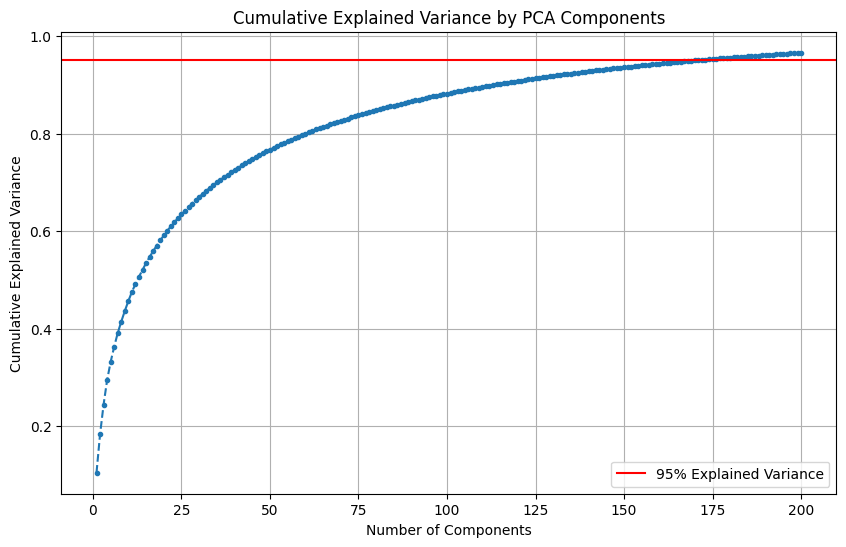

In [66]:
# The explained variance for each component
explained_variance = pca_model.explainedVariance

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance)

print(f"Total variance explained by {K_COMPONENTS} components: {cumulative_variance[-1]:.2%}")

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, K_COMPONENTS + 1), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
# Add a line for 95% variance
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend(loc='best')
plt.show()

In [67]:
# Let's find the exact number of components to explain 95% of the variance
# np.argmax will find the *first* index where the condition is True
k_optimal = np.argmax(cumulative_variance >= 0.95) + 1 
# We add 1 because a_argmax returns a 0-based index

print(f"Optimal number of components to explain 95% variance: {k_optimal}")

# Now, re-run PCA with the optimal k
pca_final = PCA(k=k_optimal, inputCol="features_vec", outputCol="pca_features")
pca_model_final = pca_final.fit(df_with_vectors)

# Transform the data
df_pca_final = pca_model_final.transform(df_with_vectors)

print("\\nShape of one of the final PCA feature vectors:")
# .size is the correct attribute for a spark vector
print(f"({df_pca_final.first()['pca_features'].size},)")

# Save these new, optimally-reduced features
pca_final_results_path = "/home/maxime/projects/P9/data/Images/Results_PCA_Optimal"
df_pca_final.select("path", "label", "pca_features").write.mode("overwrite").parquet(pca_final_results_path)

print(f"\\nOptimally-reduced PCA features saved to: {pca_final_results_path}")

Optimal number of components to explain 95% variance: 170


25/07/03 09:00:26 WARN BlockManager: Asked to remove block broadcast_39, which does not exist


\nShape of one of the final PCA feature vectors:


25/07/03 09:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB


(170,)


25/07/03 09:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1965.4 KiB


\nOptimally-reduced PCA features saved to: /home/maxime/projects/P9/data/Images/Results_PCA_Optimal


Pour conserver 95% de l'information/variance on doit utiliser 170 composantes, on sacrifie un peu d'information pour élminer beaucoup de bruit et permettre à notre modèle d'être plus efficace.

In [68]:
features_pca = spark.read.parquet(pca_final_results_path)
features_pca.printSchema()


root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pca_features: vector (nullable = true)



In [70]:
features_pca.select("path", "label", "pca_features").show(5, truncate=50)

+--------------------------------------------------+------------+--------------------------------------------------+
|                                              path|       label|                                      pca_features|
+--------------------------------------------------+------------+--------------------------------------------------+
|file:/home/maxime/projects/P9/data/Images/Test1...|  Watermelon|[-3.5224278177129853,-3.497850206812279,7.47520...|
|file:/home/maxime/projects/P9/data/Images/Test1...|   Nectarine|[9.036925092041113,-2.1647817306766046,11.39617...|
|file:/home/maxime/projects/P9/data/Images/Test1...|Cantaloupe 2|[-1.8803678362413734,2.290632304356806,10.02201...|
|file:/home/maxime/projects/P9/data/Images/Test1...|        Plum|[-1.5953731697826488,-7.410837137581141,8.41663...|
|file:/home/maxime/projects/P9/data/Images/Test1...|  Pear Stone|[-2.230829811247336,-0.1751110789364558,10.6245...|
+--------------------------------------------------+------------

In [74]:
features_pca_pd = pd.read_parquet(pca_final_results_path)
features_pca_pd

,path,label,pca_features
0,file:/home/maxime/projects/P9/data/Images/Test1/Watermelon/202_100.jpg,Watermelon,"{'type': 1, 'size': None, 'indices': None, 'values': [-3.5224278177129853, -3.497850206812279, 7.475209656979041, -1.436224434151671, -3.038100287670404, -5.071247130309258, -2.3174854903580737, 0.9967634871977575, -4.228270543602664, 9.132548453331806, -1.5701073899899223, 0.7119072179357789, -7.397779315095209, -1.7223804156134204, -1.6552458901969578, -2.459915827236259, -0.2698681882070484..."
1,file:/home/maxime/projects/P9/data/Images/Test1/Nectarine/r_34_100.jpg,Nectarine,"{'type': 1, 'size': None, 'indices': None, 'values': [9.036925092041113, -2.1647817306766046, 11.396175555507018, -9.862966396049522, -1.8321594268533616, -3.3299816354715723, -0.6628013170790579, -1.2676231774436428, -1.2612552435821012, 3.9041486206145697, -0.36007512695425614, 4.98709502770177, -5.6658650091896, -1.9104852032909387, -1.3787242837887375, -0.9343405546967517, -3.2733076852822..."
2,file:/home/maxime/projects/P9/data/Images/Test1/Cantaloupe 2/167_100.jpg,Cantaloupe 2,"{'type': 1, 'size': None, 'indices': None, 'values': [-1.8803678362413734, 2.290632304356806, 10.022016350545817, 0.737207754675721, 1.4196140038354754, -11.032379442938055, -5.755693867056284, 2.6574684136530102, -2.446666816947287, 7.07475256355789, 0.24118003692538348, 1.5510514507443625, -7.451881753951456, 4.112039837228285, 0.8730201313937563, -0.9360151990314219, -0.5873576708386954, -4..."
3,file:/home/maxime/projects/P9/data/Images/Test1/Plum/42_100.jpg,Plum,"{'type': 1, 'size': None, 'indices': None, 'values': [-1.5953731697826488, -7.410837137581141, 8.416639601063688, 5.00140900840006, -3.2885444078210124, 1.7518492989903587, -0.7446870164690048, 5.747207511553694, -7.185839758244012, 5.1080366407040785, 0.7836448511396421, 2.7668680558185246, -5.4860525964737255, -3.0564852998745864, -0.890845057654267, -0.4367239626492285, -0.8116499159696906,..."
4,file:/home/maxime/projects/P9/data/Images/Test1/Pear Stone/r2_169_100.jpg,Pear Stone,"{'type': 1, 'size': None, 'indices': None, 'values': [-2.230829811247336, -0.1751110789364558, 10.624535146031137, 1.6171051972206623, -3.2248042008409095, -3.1449085258057243, -6.858349186081882, -0.4397775659792344, -4.5070568388789365, 1.8991678056794299, -1.813642194761351, 5.34168532969678, -5.889996632252845, 2.4106679328668794, 1.8828051887260824, -3.394251240423453, -1.7189481880230364..."
...,...,...,...
388,file:/home/maxime/projects/P9/data/Images/Test1/Apricot/78_100.jpg,Apricot,"{'type': 1, 'size': None, 'indices': None, 'values': [8.164863463223348, 1.7586406919862596, 4.782824680146383, -3.3067939693800708, -1.1739272483384269, -8.422216108018826, 1.177800428711086, 4.066789462671121, -5.523292958409511, 10.938961798972194, 1.996253915626794, -0.02599326740140029, -3.7470347735123797, -0.4740315409240869, 0.19429450599584283, 1.9567836421532465, -5.835867645538573, ..."
389,file:/home/maxime/projects/P9/data/Images/Test1/Mulberry/r_190_100.jpg,Mulberry,"{'type': 1, 'size': None, 'indices': None, 'values': [-3.8121759869630107, -8.38292205377264, 3.3607468166371426, -1.3953941542310502, 0.24153065190494039, -0.6515036178100362, 1.3169889554273846, -1.0968428265343826, -8.29215880200392, 6.17487849510996, 0.6701202131006557, 0.3735550970030179, -1.6949639748297143, -0.8367012673382431, -1.9407443654689853, -2.326718381806256, -5.660215528879717..."
390,file:/home/maxime/projects/P9/data/Images/Test1/Salak/266_100.jpg,Salak,"{'type': 1, 'size': None, 'indices': None, 'values': [-0.1576993508932556, -6.821556294957941, 5.721832005601392, -9.025989427269712, -3.043770714843563, -9.521842103920287, -0.7850495966731414, -0.2514326210115846, -7.761625862660662, 6.078772505227302, -2.284113341690436, 0.684242319587038, -8.126165830874918, -4.942746124765982, 1.924834167854661, -3.292666826578456, -3.7687926113259236, 1...."
391,file:/home/maxime/projects/P9/data/Images/Test1/Grape White/r_115_100.jpg,Grape White,"

In [78]:
features_pca_pd.loc[0, "pca_features"].keys()

dict_keys(['type', 'size', 'indices', 'values'])

type: 1 signifies a DenseVector. This means that the vector stores a value for every single position (component).